In [1]:
from keras.models import load_model

from art.utils import load_dataset
from art.classifiers import KerasClassifier
from art.attacks.fast_gradient import FastGradientMethod
from art.attacks.iterative_method import BasicIterativeMethod
from art.defences.adversarial_trainer import AdversarialTrainer
from art.utils import load_mnist, random_targets

import numpy as np

from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

In [3]:
classifier_model = load_model("./mnist_cnn_original.h5")
classifier = KerasClassifier((min_, max_), classifier_model, use_logits=False)
classifier.fit(x_train, y_train, batch_size=100, nb_epochs=10)

Epoch 1/10
600/600 [==============================] - 35s 59ms/step - loss: 0.0016 - acc: 0.9997
Epoch 2/10
600/600 [==============================] - 32s 54ms/step - loss: 7.0949e-04 - acc: 0.9999
Epoch 3/10
600/600 [==============================] - 46s 77ms/step - loss: 7.6020e-04 - acc: 0.9999
Epoch 4/10
600/600 [==============================] - 45s 75ms/step - loss: 2.7627e-04 - acc: 1.0000
Epoch 5/10
600/600 [==============================] - 38s 64ms/step - loss: 2.6950e-04 - acc: 1.0000
Epoch 6/10
600/600 [==============================] - 35s 58ms/step - loss: 2.7200e-04 - acc: 1.0000
Epoch 7/10
600/600 [==============================] - 44s 73ms/step - loss: 3.7362e-07 - acc: 1.0000
Epoch 8/10
600/600 [==============================] - 44s 74ms/step - loss: 2.6885e-04 - acc: 1.0000
Epoch 9/10
600/600 [==============================] - 32s 53ms/step - loss: 5.3749e-04 - acc: 1.0000
Epoch 10/10
600/600 [==============================] - 36s 60ms/step - loss: 2.1961e-07 - acc: 

In [4]:
classifier

In [7]:
num_of_test = 500

# Origin Classifier

In [8]:
x_test_pred = np.argmax(classifier.predict(x_test[:num_of_test]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:num_of_test], axis=1))

print("Original test data (first {} images):".format(num_of_test))
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(num_of_test-nb_correct_pred))# which netural network

Original test data (first 500 images):
Correctly classified: 495
Incorrectly classified: 5


### The original images

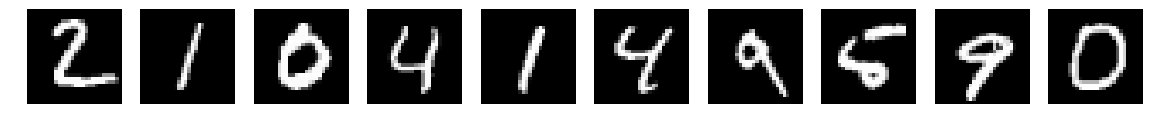

In [9]:
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(x_test[i].reshape((28,28)), cmap='gray')
plt.show()

# Attacked by FGSM

In [10]:
attacker = FastGradientMethod(classifier, eps=0.5)
x_test_adv = attacker.generate(x_test[:num_of_test])

In [11]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:num_of_test], axis=1))

print("Adversarial test data (first 500 images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num_of_test-nb_correct_adv_pred))

Adversarial test data (first 500 images):
Correctly classified: 149
Incorrectly classified: 351


### Images generated by Fast Gradient Method

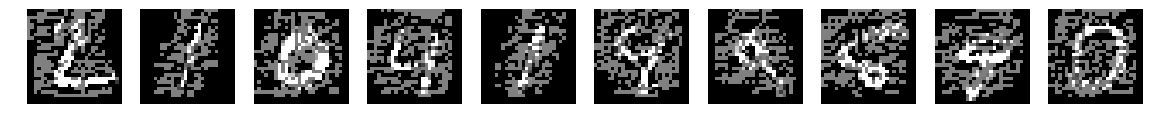

In [12]:
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(x_test_adv[i].reshape((28,28)), cmap='gray')
plt.show()

### save the adversarial files generated by FGSM

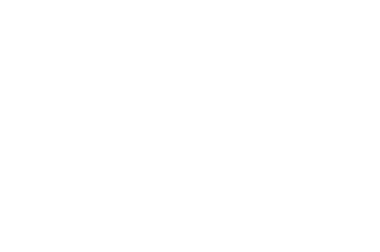

In [13]:
import matplotlib
for i in range(num_of_test):
    plt.axis('off')
    matplotlib.image.imsave('fgsm_files/' + str(i) + '.png', x_test_adv[i].reshape((28,28)))

# Attacked by CW

In [30]:
from art.attacks.carlini import CarliniL2Method
import logging

In [131]:
num_of_test = 200
attacker = CarliniL2Method(classifier, targeted=True, max_iter=100)
params = {'y': random_targets(y_test, classifier.nb_classes)}
x_test_adv = attacker.generate(x_test[:num_of_test], **params)

In [132]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:num_of_test], axis=1))

print("Adversarial test data (first {} images):".format(num_of_test))
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num_of_test-nb_correct_adv_pred)) # target or untarget

Adversarial test data (first 200 images):
Correctly classified: 45
Incorrectly classified: 155


### Images generated by CW Method

The iamges are generated quite slow if using CW method

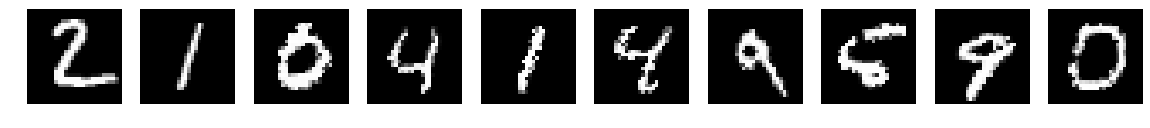

In [133]:
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(x_test_adv[i].reshape((28,28)), cmap='gray')
plt.show()

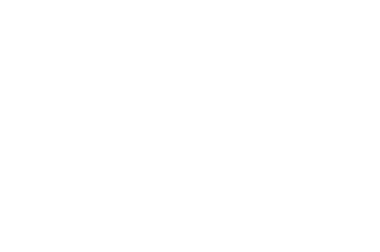

In [134]:
import matplotlib
for i in range(num_of_test):
    plt.axis('off')
    matplotlib.image.imsave('cw/' + str(i) + '.png', x_test_adv[i].reshape((28,28)))

----------------

# Defense method

### Accuracy when the input is JPEG format of adversarial examples generated by FGSM

In [56]:
num_of_test = 500

# transform to jpeg
for i in range(num_of_test):
    im = Image.open("fgsm_files/" + str(i) + ".png")
    im = im.convert('RGB')
    im.save("jpeg_fgsm_75/" + str(i) + ".jpeg", "JPEG", quality=75)

In [57]:
from skimage import io
p = []
for i in range(num_of_test):
    img = io.imread('jpeg_fgsm_75/' + str(i) + '.jpeg', as_gray=True)
    img = img.reshape((28,28,1))
    p.append(img)
p = np.stack(tuple(p))

In [58]:
# get the true label for these examples
with open("true_label.txt", "r") as f:
    true_label = f.read()
true_label = [int(i) for i in true_label]
tmp = np.zeros((len(true_label), 10))
for i, v in enumerate(true_label):
    tmp[i][v] = 1
true_label = tmp

In [59]:
x_test_adv_pred = np.argmax(classifier.predict(p), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(true_label[:num_of_test], axis=1))

print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num_of_test-nb_correct_adv_pred))

Correctly classified: 160
Incorrectly classified: 340


### Accuracy when the input is JPEG format of adversarial examples generated by CW

Transfrom png to jpeg with quality been 75

In [150]:
num_of_test = 200
for i in range(num_of_test):
    im = Image.open("cw/" + str(i) + ".png")
    im = im.convert('RGB')
    im.save("jpeg_cw_75/" + str(i) + ".jpeg", "JPEG", quality=50)

In [151]:
p = []
for i in range(num_of_test):
    img = io.imread('jpeg_cw_75/' + str(i) + '.jpeg', as_grey=True)
    img = img.reshape((28,28,1))
    p.append(img)
p = np.stack(tuple(p))

In [152]:
# get the true label for these examples
with open("true_label.txt", "r") as f:
    true_label = f.read()
true_label = [int(i) for i in true_label]
tmp = np.zeros((len(true_label), 10))
for i, v in enumerate(true_label):
    tmp[i][v] = 1
true_label = tmp

In [153]:
x_test_adv_pred = np.argmax(classifier.predict(p), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(true_label[:num_of_test], axis=1))

print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num_of_test-nb_correct_adv_pred))

Correctly classified: 68
Incorrectly classified: 132


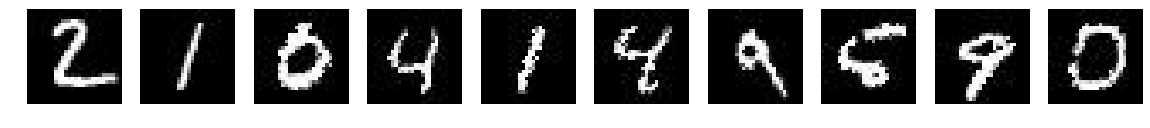

In [149]:
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(p[i].reshape((28,28)), cmap='gray')
plt.show()

-------

### Accuracy when the input is filtered by high or low pass filter

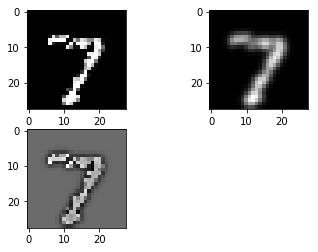

In [6]:
from scipy import ndimage
from skimage import io
import matplotlib

def plot(data):
    plot.i += 1
    plt.subplot(2,2,plot.i)
    plt.imshow(data)
    plt.gray()
plot.i = 0

im = io.imread('cw/' + str(0) + '.png', as_gray=True)
data = np.array(im, dtype=float)
plot(data)

lowpass = ndimage.gaussian_filter(data, 1)
gauss_highpass = data - lowpass
plot(lowpass)
plot(gauss_highpass)

# RESULT

In [164]:
num_of_test = 200

for i in range(num_of_test):
    im = io.imread('cw/' + str(i) + '.png', as_gray=True)
    data = np.array(im, dtype=float)

    lowpass = ndimage.gaussian_filter(data, 1)
    gauss_highpass = data - lowpass
    matplotlib.image.imsave('low_pass_filter_cw/' + str(i) + '.png', lowpass)

In [165]:
p = []
for i in range(num_of_test):
    img = io.imread('low_pass_filter_cw/' + str(i) + '.png', as_grey=True)
    img = img.reshape((28,28,1))
    p.append(img)
p = np.stack(tuple(p))

In [166]:
x_test_adv_pred = np.argmax(classifier.predict(p), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(true_label[:num_of_test], axis=1))

print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num_of_test-nb_correct_adv_pred))

Correctly classified: 198
Incorrectly classified: 2


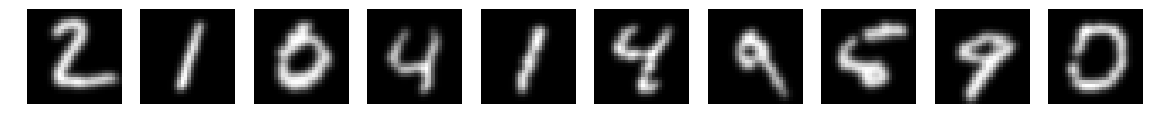

In [167]:
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(p[i].reshape((28,28)), cmap='gray')
plt.show()

In [191]:
p = []
for i in range(num_of_test):
    img = io.imread('jpeg_cw_10/' + str(i) + '.jpeg', as_grey=True)
    img = img.reshape((28,28,1))
    p.append(img)
p = np.stack(tuple(p))

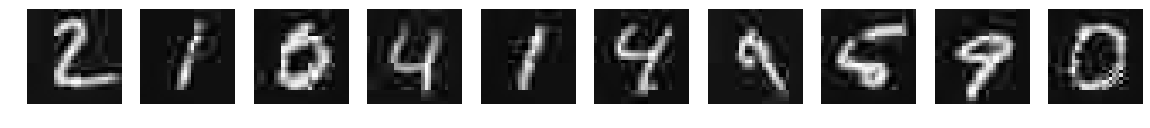

In [192]:
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(p[i].reshape((28,28)), cmap='gray')
plt.show()

In [8]:
p = []
num_of_test = 200
for i in range(num_of_test):
    img = io.imread('hr/' + str(i) + '_ne1x.png', as_gray=True)
    img = img.reshape((28,28,1))
    p.append(img)
p = np.stack(tuple(p))

In [9]:
# get the true label for these examples
with open("true_label.txt", "r") as f:
    true_label = f.read()
true_label = [int(i) for i in true_label]
tmp = np.zeros((len(true_label), 10))
for i, v in enumerate(true_label):
    tmp[i][v] = 1
true_label = tmp

In [10]:
x_test_adv_pred = np.argmax(classifier.predict(p), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(true_label[:num_of_test], axis=1))

print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(num_of_test-nb_correct_adv_pred))

Correctly classified: 196
Incorrectly classified: 4


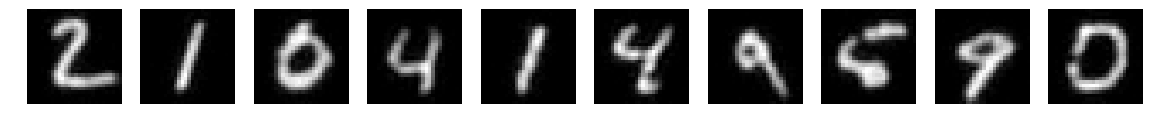

In [11]:
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(p[i].reshape((28,28)), cmap='gray')
plt.show()

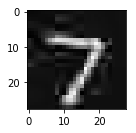

In [25]:
def plot(data):
    plot.i += 1
    plt.subplot(2,2,plot.i)
    plt.imshow(data)
    plt.gray()
plot.i = 0

im = io.imread('0_ne1x.png', as_gray=True)
data = np.array(im, dtype=float)
plot(data)

In [27]:
matplotlib.image.imsave('0_ne1xxx.png', data)